### 必要なモジュールを読み込む

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

### MNISTデータの取得とプレビュー
- mnist.train.images: 訓練用イメージデータが配列で格納されている。1枚のイメージはベクトルになっていることに注意。
- mnist.train.labels: 訓練用のラベルデータ。1-of-K 表現。
- mnist.validation.images: バリデーション用イメージデータ。
- mnist.validation.labels: バリデーション用ラベルデータ。
- mnist.test.images: テスト用イメージデータ。
- mnist.test.labels: テスト用ラベルデータ。

In [2]:
# データのダウンロードと展開
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


[7 3 4 6]


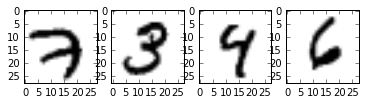

In [3]:
# 訓練画像の先頭４毎を描画
for i in range(0, 4):
    plt.subplot(141 + i)
    plt.imshow(-mnist.train.images[i].reshape(28, 28), cmap=plt.cm.gray)
print(np.argmax(mnist.train.labels[0:4,], axis=1))

## TensorFlow でMLP
### 学習したいモデルを記述する

In [4]:
# 入力変数と出力変数のプレースホルダを生成
x = tf.placeholder(tf.float32, [None, 784], name='Image')
y_ = tf.placeholder(tf.float32, [None, 10], name='true_label')

# モデル式 (入力層:784ノード, 隠れ層:100ノード, 出力層:10ノード)
with tf.name_scope('fc_1'):
    W1 = tf.Variable(tf.truncated_normal([784, 100]), name='weight')
    b1 = tf.Variable(tf.zeros([100]), name='bias')
    h = tf.sigmoid(tf.matmul(x, W1) + b1) # 入力層->隠れ層

with tf.name_scope('fc_2'):
    W2 = tf.Variable(tf.truncated_normal([100, 10]), name='weight')
    b2 = tf.Variable(tf.zeros([10]), name='bias')
    u = tf.matmul(h, W2) + b2    # 隠れ層->出力層 (ロジット)
    y = tf.nn.softmax(u)         # 隠れ層->出力層 (ソフトマックス後)

### 学習やテストに必要な関数を定義する

In [5]:
with tf.name_scope('train'):
    # 誤差関数(loss)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(u, y_), name='Xent')
    xent_summ = tf.scalar_summary('learning/XEnt', loss)
    # 最適化手段(最急降下法)
    global_step = tf.Variable(0, name='global_step', trainable=False)
    train_step = tf.train.GradientDescentOptimizer(0.01).minimize(loss, global_step=global_step)

with tf.name_scope('eval'):
    # 正答率
    correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
    acc = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name='Accuracy')
    acc_summ = tf.scalar_summary('learning/Accuracy', acc)

### 実際に学習処理を実行する

In [6]:
# すべてのサマリーを統合
merged_summ = tf.merge_all_summaries()

# セッションを準備し，変数を初期化
sess = tf.Session()

# セッション作成後に SummaryWriter を呼ぶことで， グラフ構造が出力される。
train_writer = tf.train.SummaryWriter('data/mnist/train', graph=sess.graph, flush_secs=10)
valid_writer = tf.train.SummaryWriter('data/mnist/valid', flush_secs=10)

init = tf.initialize_all_variables()
sess.run(init)

In [ ]:
for i in range(1000):
    # バッチ型確率的勾配降下法でパラメータ更新
    batch_xs, batch_ys = mnist.train.next_batch(100)
    _, train_xent, train_acc, train_merged_summ, step = sess.run(
        [train_step, loss, acc, merged_summ, global_step], feed_dict={x: batch_xs, y_: batch_ys})
    train_writer.add_summary(train_merged_summ, step)
    
    if (i + 1) % 100 == 0:
        # 100回の更新ごとに予測性能を出力
        valid_xent, valid_acc, valid_merged_summ, step = sess.run([loss, acc, merged_summ, global_step], 
                                         feed_dict={x: mnist.validation.images[0:1000], y_: mnist.validation.labels[0:1000]})
        valid_writer.add_summary(valid_merged_summ, step)
        print ("step=%3d, Xent(train)=%.2f, Acc(train)=%.2f, Xent(valid)=%.2f, Acc(valid)=%.2f" % 
               (step, train_xent, train_acc, valid_xent, valid_acc))

step=3100, Xent(train)=1.09, Acc(train)=0.68, Xent(valid)=1.06, Acc(valid)=0.70
step=3200, Xent(train)=1.43, Acc(train)=0.62, Xent(valid)=1.04, Acc(valid)=0.70
step=3300, Xent(train)=1.09, Acc(train)=0.68, Xent(valid)=1.02, Acc(valid)=0.70
step=3400, Xent(train)=1.43, Acc(train)=0.56, Xent(valid)=1.01, Acc(valid)=0.70
step=3500, Xent(train)=1.09, Acc(train)=0.68, Xent(valid)=1.00, Acc(valid)=0.71
step=3600, Xent(train)=1.08, Acc(train)=0.64, Xent(valid)=0.98, Acc(valid)=0.71
step=3700, Xent(train)=0.95, Acc(train)=0.71, Xent(valid)=0.97, Acc(valid)=0.72
step=3800, Xent(train)=0.74, Acc(train)=0.76, Xent(valid)=0.96, Acc(valid)=0.72


In [ ]:
# バッファ内のサマリーデータを出力する
train_writer.flush()
valid_writer.flush()

### 後片付け

In [16]:
# セッションを閉じる
sess.close()